##### Copyright 2018 Krzysztof Rusek, José Suárez-Varela, Albert Mestres, Pere Barlet-Ros, Albert Cabellos-Aparicio.
AGH University of Science and Technology, Universitat Politècnica de
Catalunya

Licensed under the MIT License (the "License");


In [0]:
#@title Licensed under the MIT License (the "License"); { display-mode:"form" }
# MIT License

# Copyright (c) 2018 Krzystzof Rusek and Lucjan Janowski

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Unveiling the potential of Graph Neural Networks for network modeling and optimization in SDN - Demo
This notebook shows how to apply the trained route model on a custom network.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/krzysztofrusek/net2vec/blob/master/jupyter_notebooks/RouteNet_Inference.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/krzysztofrusek/net2vec/tree/master/jupyter_notebooks/RouteNet_Inference.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>



## Dataset

Let us begin with cloning the repository from GitHub. Once done, we need to download and uncompress the checkpoint containing the weights of the network.

In [1]:
! git clone https://github.com/krzysztofrusek/net2vec
  
! wget http://knowledgedefinednetworking.org/data/trained_model_delay.zip
  
! unzip -fo trained_model_delay.zip

fatal: destination path 'net2vec' already exists and is not an empty directory.
--2019-03-25 16:39:17--  http://knowledgedefinednetworking.org/data/trained_model_delay.zip
Resolving knowledgedefinednetworking.org (knowledgedefinednetworking.org)... 147.83.130.144
Connecting to knowledgedefinednetworking.org (knowledgedefinednetworking.org)|147.83.130.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3176159 (3.0M) [application/zip]
Saving to: ‘trained_model_delay.zip.2’

trained_model_delay 100%[===================>]   3.03M  2.41MB/s    in 1.3s    

2019-03-25 16:39:19 (2.41 MB/s) - ‘trained_model_delay.zip.2’ saved [3176159/3176159]

Archive:  trained_model_delay.zip


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import importlib
import sys
import networkx as nx

tfe = tf.contrib.eager



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
sys.path.append('./net2vec/routenet')

In [0]:
upc=importlib.import_module('routenet')

# Model

The model was trained for particular hyperparameters. In order to get correct predictions, one needs to use exactly the same values for the inference. 
Since RouteNet is implemented as a keras model it can be easily restored from the checkpoint.

**Pay attention to run this part only once when using eager mode, because the second model will have different names of the variables**.

In the future this will move to `tf.train.Checkpoint`

In [5]:
tf.enable_eager_execution()

hparams = upc.hparams.parse("l2=0.1,dropout_rate=0.5,link_state_dim=16,path_state_dim=32,readout_units=256,learning_rate=0.001,T=8")

model = upc.ComnetModel(hparams)
model.build()

saver =  tfe.Saver(model.variables)
saver.restore('nsf_delay_model/model.ckpt-292933')

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from nsf_delay_model/model.ckpt-292933


# Network

In this notebook, we are going to predict the delay in a random network with shortest path routing. Let's use Barabasi-Alber small world model of a network with $n$ nodes. Python package `networkx` implements generators and shortest path computation routines.

The traffic matrix is randomly generated from a uniform distribution : $TM\sim Uni(0.1,1.1)$ that resembles demands used in the simulation. 
Note that we assume constant link speed the same as described in the paper.

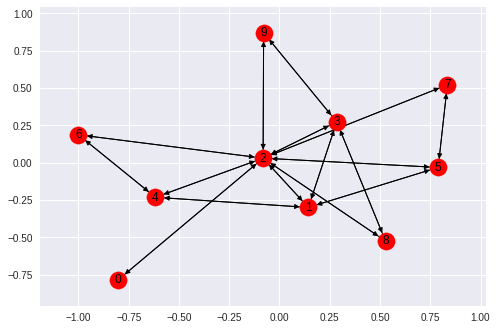

In [46]:
#@title Simulation parameters { display-mode:"form" }
#@markdown Number of nodes in the network
n=10 #@param 

G = nx.barabasi_albert_graph(n,2)
G = nx.DiGraph(G)

nx.draw_networkx(G)

TM = np.random.uniform(low=0.1,high=1.1,size=n*(n-1))

Find the shortest paths

In [0]:
all_pairs=dict(nx.all_pairs_dijkstra_path(G))
edges=list(G.edges)


In `networkx` edges are defined by the pair of endpoints. In RouteNet, the network is defined with links in mind, thus we need to convert the presentation and create indices used as an input of RouteNet.

In [48]:
paths=[]
path_names=[]
for i in range(n):
    for j in range(n):
        if i != j:
            paths.append([edges.index(tup) for tup in upc.pairwise(all_pairs[i][j])])
            path_names.append((i,j))
len(paths)

90

# Inference

The RouteNet takes traffic matrix and routing matrix as an input. These are the features, however, the routing is preprocessed to allow the model trained on one topology to generalize.
The routing scheme in the network by a set of paths $\mathcal{R}=\{p_k\} \quad k \in (0,1,\ldots,n_p) $. Each path is defined as a sequence of links $p_k=(l_{k(0)},\ldots, l_{k(|p_k|)})$, where $k(i)$ is the index of the $i$-th link in the path $k$.  

These sequences are represented by indices for efficient manipulation in TensorFlow. The code below shows how to prepare the input to the network.

Notice how scaling and shifting are applied to match the operations used during the training. The inference is repeated 50 times with active dropout - this makes the random prediction and allows to estimate the confidence.

In [0]:
link_indices, path_indices, sequ_indices = upc.make_indices(paths)

n_paths = n*(n-1)
n_links = max(max(paths))+1
n_total = len(path_indices)

tm = tf.convert_to_tensor((TM-0.5)/0.5,dtype=tf.float32)

feature={
            'traffic':tf.convert_to_tensor(tm,dtype=tf.float32),
            'links':link_indices,
            'paths':path_indices,
            'sequances':sequ_indices,
            'n_links':n_links, 
            'n_paths':n_paths,
            'n_total':n_total
        }

# set training=True to enable dropout, this approximates posterior predictive distribution
hats = [  model(feature, training=True).numpy() for i in range(50)]

# scaling and shifting parameters from training set
hats = 2.5*np.concatenate(hats,axis=1)+2.8

prediction = np.median(hats,axis=1)

conf = np.percentile(hats,q=[5,95],axis=1)

# Visualisation

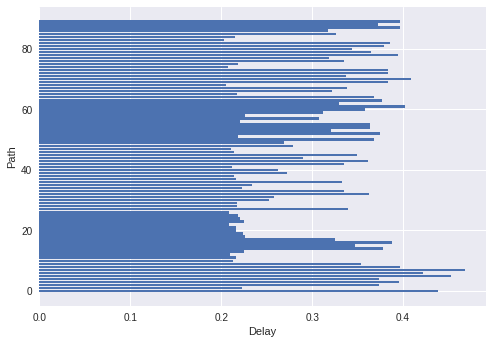

In [50]:
ax = plt.subplot()
ax.barh(y=range(n*(n-1)),width=prediction)
ax.set_xlabel("Delay");
ax.set_ylabel('Path');


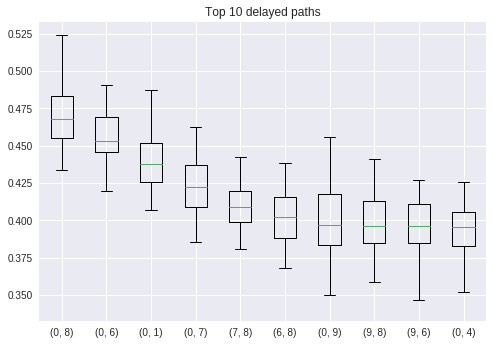

In [51]:
idx = (-prediction).argsort()[:10]
labels = [str(path_names[x]) for x in idx]

ax = plt.subplot()
ax.boxplot(hats[idx,:].T, labels=labels);
ax.set_title("Top 10 delayed paths");

# References

*Unveiling the potential of GNN for network modeling and optimization in SDN* by K. Rusek, J. Suárez-Varela, A. Mestres, P. Barlet-Ros, A. Cabellos-Aparicio accepted for ACM Symposium on SDN Research, April 2019, San Jose, CA, USA. [arXiv:1901.08113](https://arxiv.org/abs/1901.08113)